In [18]:
using Diffusions, Random, StatsBase, Flux, OneHotArrays, Distributions, Plots, Random, StatsPlots, LaTeXStrings

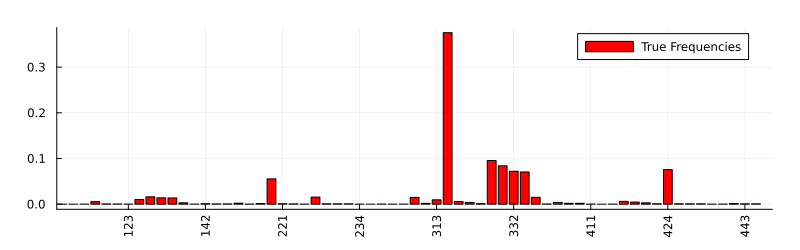

In [2]:
#Setting up a toy Markov sequence generator
S = [0.06591801058555521, 0.07969206822877058, 0.7577065839917972, 0.09668333719387696]
M1 = [0.08846562872099392 0.16990851783433247 0.7057593661240716 0.035866487320601916; 0.7431475939699389 0.21587009667771628 0.03183492266912633 0.009147386683218569; 0.5299436666548881 0.14037279287634963 0.31880667650890665 0.010876863959855763; 0.06768187476034546 0.8712803961334261 0.026959057317955764 0.03407867178827272]
M2 = [0.03711853694508748 0.004654670142378095 0.02356516471832978 0.9346616281942046; 0.05468190341435613 0.035849693778767566 0.010983526474084716 0.8984848763327916; 0.34718976966999127 0.29844003126407787 0.29174999882526814 0.06262020024066273; 0.06343354243884528 0.46980429610053 0.23584821143715762 0.23091395002346707]


#=
#If you wanted to draw the seq gen randomly
S = exp.(randn(4) .* 1.5)
S ./= sum(S)

M1 = exp.(randn(4,4) .* 1.5)
M1 ./= sum(M1 , dims = 2)

M2 = exp.(randn(4,4) .* 1.5)
M2 ./= sum(M2 , dims = 2)
=#


function target_sample(;S = S, M1 = M1, M2 = M2)
    a = rand(Categorical(S))
    b = rand(Categorical(M1[a,:]))
    c = rand(Categorical(M2[b,:]))
    return [a,b,c]
end

seq_matrix = hcat([[k,j,i] for i in 1:4, j in 1:4, k in 1:4]...)
all_seqs = [seq_matrix[:,i] for i in 1:size(seq_matrix,2)];
prob_seq(seq,S,M1,M2) = S[seq[1]]*M1[seq[1],seq[2]]*M2[seq[2],seq[3]]
all_probs = prob_seq.(all_seqs,Ref(S),Ref(M1),Ref(M2));

bar([join(string.(a)) for a in all_seqs], all_probs,
    xrotation = 90, size = (800,250), label = "True Frequencies",
    color = "red", margins = 0.5Plots.cm, xlim = (0,65))

In [3]:
#Setting up the model
alph = 4 #number of characters
hidden_size = 64

#We encode T with a non-trainable random projection
rff = RandomFourierFeatures(hidden_size, 1.0f0)

#A simple model that takes the full noised sequence and T,
#and returns the logits for each variable in the sequence
embed = Chain(Dense(12,hidden_size,leakyrelu),Dense(hidden_size,hidden_size,leakyrelu))
decode = Chain(
    Dense(hidden_size, hidden_size),LayerNorm(hidden_size),leakyrelu,
    Dense(hidden_size, hidden_size),LayerNorm(hidden_size),leakyrelu,
    Dense(hidden_size, hidden_size),LayerNorm(hidden_size),leakyrelu,
    Dense(hidden_size, hidden_size),LayerNorm(hidden_size),leakyrelu,
    Dense(hidden_size, hidden_size÷2),LayerNorm(hidden_size÷2),leakyrelu,
    Dense(hidden_size÷2, 12)
)
model(x,T) = reshape(
    decode(
        embed(
            reshape(x,(12,size(x)[end]))
             ) .+ rff(log(T))
           ),
    (4,3,size(x)[end]));

In [4]:
#Setting up the timestep schedule
timesteps = log_schedule(Float32(0.001),Float32(20.0),100)

#Define the discrete diffusion process
P = UniformDiscreteDiffusion(1.0,alph)

batch_size = 8
ps = Flux.params(embed, decode)
opt = Flux.Optimiser(WeightDecay(0.0001), Adam(0.0001))#Adam(0.001))
cumu_loss = 0.0
training_losses = Float64[];

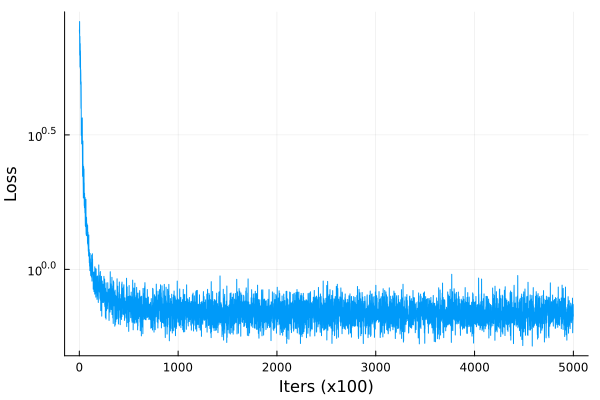

In [5]:
for iter in 1:500000
    #Generate one batch of training data
    x = hcat([target_sample() for i in 1:batch_size]...)
    datOH = onehotbatch(x, 1:alph)

    #Sample T, then diffuse
    T = rand(timesteps)    
    diffused = sampleforward(P, T, x)
    diffusedOH = onehotbatch(diffused, 1:alph)
    
    #For scaling the loss
    scal = sqrt(1 - exp(-T))
    
    #Loss and gradient
    l,gs = Flux.withgradient(ps) do
        #The cross entropy loss is important for recovering the data distribution
        Flux.logitcrossentropy(model(diffusedOH,T), datOH)/scal
    end
    #Update the parameters
    Flux.Optimise.update!(opt, ps, gs)
    
    cumu_loss += l
    if mod(iter,100) == 0
        opt[2].eta = opt[2].eta * 0.998 #Cheeky decay
        push!(training_losses, cumu_loss/100)
        cumu_loss = 0.0
        #Plotting loss
        IJulia.clear_output(true)
        plot(training_losses, yscale = :log10, ylabel = "Loss", xlabel = "Iters (x100)", label = :none) |> IJulia.display
        sleep(0.01)
    end
end

IJulia.clear_output(true)
pl = plot(training_losses, yscale = :log10, ylabel = "Loss", xlabel = "Iters (x100)", label = :none)

savefig(pl,"discrete_loss.pdf")
pl

In [6]:
#First draw samples from the equilibrium distribution of the process
eq = eq_dist(P)
N = 20000
x_T = hcat([[rand(eq) for i in 1:3] for i in 1:N]...)

#Instead of an expectation, discrete diffusion needs us to draw a sample from the marginal for each variable
function zero_sample(x_t, t)
    diffusedOH = onehotbatch(x_t, 1:alph)
    return randcat(softmax(model(diffusedOH,t)))
end

#Run the backward diffution
@time samp = samplebackward(zero_sample, P, timesteps, x_T);

#Collect these samples
diff_samples = [samp[:,i] for i in 1:size(samp,2)];

 13.380264 seconds (8.33 M allocations: 13.869 GiB, 30.77% gc time, 17.23% compilation time)


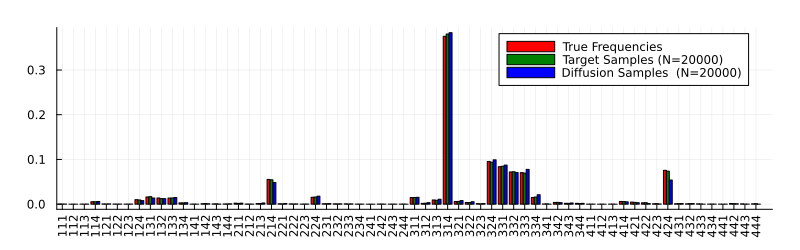

In [7]:
#Plotting
target_samples = [target_sample() for i in 1:N];
prop_d = proportionmap(diff_samples)
target_d = proportionmap(target_samples)
diff_freqs = [get(prop_d,a,0.0) for a in all_seqs]
target_freqs = [get(target_d,a,0.0) for a in all_seqs]

pl = groupedbar([join(string.(a)) for a in all_seqs], [all_probs target_freqs diff_freqs],
    xrotation = 90, size = (800,250), label = ["True Frequencies" "Target Samples (N=$(N))" "Diffusion Samples  (N=$(N))"],
    color = ["red" "Green" "blue"], margins = 0.5Plots.cm, xlim = (0,65))
savefig(pl,"discrete_diff_flux64.pdf")
pl

In [8]:
#And how to do it with IJ, which takes one-hots
P = IndependentDiscreteDiffusion((alph-1)/alph,ones(alph)) #This should be equiv to UniformDiscreteDiffusion(1.0,alph)

IndependentDiscreteDiffusion{Float64}(0.75, [0.25, 0.25, 0.25, 0.25], 1.3333333333333333)

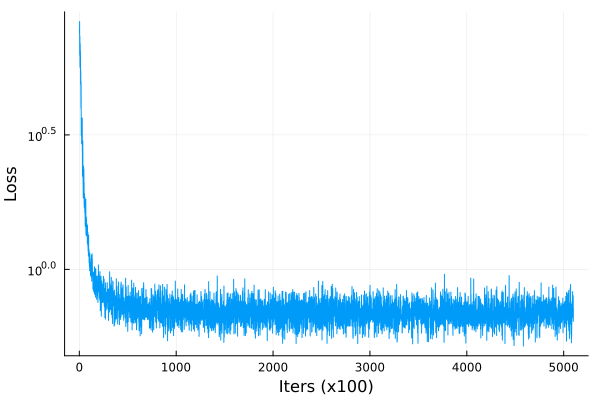

In [9]:
#Since this IndependentDiscreteDiffusion process is equivalent, the model from above should be "pre-trained"
#let's check if the loss resumes from where it left off
for iter in 1:10000
    x = hcat([target_sample() for i in 1:batch_size]...)
    datOH = onehotbatch(x, 1:alph)
    T = rand(timesteps)    
    diffusedOH = sampleforward(P, T, datOH) #Note, we diffuse the one-hots
    scal = sqrt(1 - exp(-T))
    l,gs = Flux.withgradient(ps) do
        Flux.logitcrossentropy(model(diffusedOH,T), datOH)/scal
    end
    Flux.Optimise.update!(opt, ps, gs)
    cumu_loss += l 
    if mod(iter,100) == 0
        opt[2].eta = opt[2].eta * 0.997
        push!(training_losses, cumu_loss/100)
        cumu_loss = 0.0
        IJulia.clear_output(true)
        plot(training_losses, yscale = :log10, ylabel = "Loss", xlabel = "Iters (x100)", label = :none) |> IJulia.display
        sleep(0.01)
    end
end
IJulia.clear_output(true)
plot(training_losses, yscale = :log10, ylabel = "Loss", xlabel = "Iters (x100)", label = :none)

In [10]:
function zero_sample(x_t, t)
    #randcat here maintains onehot
    sm = softmax(model(x_t,t))
    return onehotbatch(randcat(sm),1:size(sm,1))
end

eq = Categorical(ones(alph)./alph);
N = 10000
#We init with onehots
x_T = onehotbatch(hcat([[rand(eq) for i in 1:3] for i in 1:N]...), 1:alph);

@time samp = onecold(samplebackward(zero_sample, P, timesteps, x_T),1:alph);
diff_samples = [samp[:,i] for i in 1:size(samp,2)];

  6.777294 seconds (6.46 M allocations: 7.666 GiB, 34.53% gc time, 17.60% compilation time)


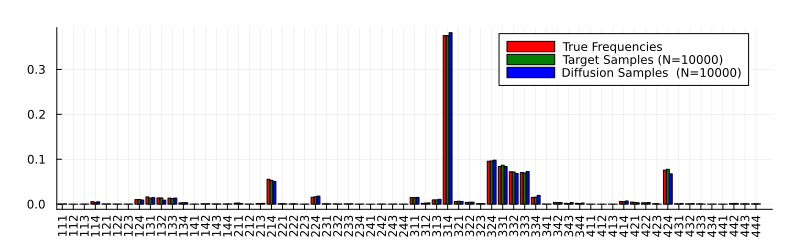

In [11]:
target_samples = [target_sample() for i in 1:N];
prop_d = proportionmap(diff_samples)
target_d = proportionmap(target_samples)
diff_freqs = [get(prop_d,a,0.0) for a in all_seqs]
target_freqs = [get(target_d,a,0.0) for a in all_seqs]

pl = groupedbar([join(string.(a)) for a in all_seqs], [all_probs target_freqs diff_freqs],
    xrotation = 90, size = (800,250), label = ["True Frequencies" "Target Samples (N=$(N))" "Diffusion Samples  (N=$(N))"],
    color = ["red" "Green" "blue"], margins = 0.5Plots.cm, xlim = (0,65))
savefig(pl,"discrete_diff_fluxIJ.pdf")
pl

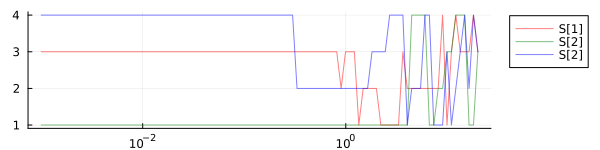

In [12]:
#A trajectory with an NN-trained model
x_T = onehotbatch(hcat([[rand(eq) for i in 1:3] for i in 1:1]...), 1:alph);
track = Diffusions.Tracker()
samp = onecold(samplebackward(zero_sample, P, timesteps, x_T, tracker = track),1:alph);

#An example of a single discrete trajectory
plot(track.time,hcat([v[:] for v in onecold.(track.data,(1:alph,))]...)', xscale = :log10, alpha = 0.5, size = (600,150), 
    legend=:outertopright, color = ["red" "green" "blue"], label = ["S[1]" "S[2]" "S[2]"])

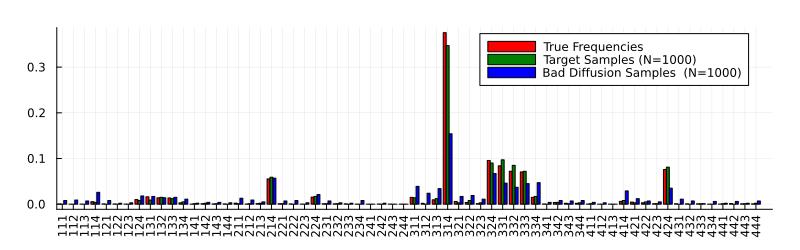

In [13]:
#Using the expected freqs, without sampling, does NOT work for the discrete case!
function expect(x_t, t)
    return softmax(model(x_t,t)) #Just the exepected freqs
end

N = 1000
x_T = onehotbatch(hcat([[rand(eq) for i in 1:3] for i in 1:N]...), 1:alph);

samp = onecold(samplebackward(expect, P, timesteps, x_T),1:alph);
diff_samples = [samp[:,i] for i in 1:size(samp,2)];

target_samples = [target_sample() for i in 1:N];
prop_d = proportionmap(diff_samples)
target_d = proportionmap(target_samples)
diff_freqs = [get(prop_d,a,0.0) for a in all_seqs]
target_freqs = [get(target_d,a,0.0) for a in all_seqs]

pl = groupedbar([join(string.(a)) for a in all_seqs], [all_probs target_freqs diff_freqs],
    xrotation = 90, size = (800,250), label = ["True Frequencies" "Target Samples (N=$(N))" "Bad Diffusion Samples  (N=$(N))"],
    color = ["red" "Green" "blue"], margins = 0.5Plots.cm, xlim = (0,65))
savefig(pl,"discrete_diff_flux_nosample.pdf")
pl

In [14]:
#Closed-form (ie. no trained NN) to investigate behavior/convergence etc.

#"product of marginals" for each variable in the sequence
#This is what you get from the backward pass, because each variable is diffused independently
#For the closed form calculation, this is P(xt|x0), where "seq" is x0, considered as a function of x0.
independent_seq_prob(seq,state) = state[seq[1],1]*state[seq[2],2]*state[seq[3],3]

#The above gets multiplied by P(x0) (ie. all_probs, the target distribution) to get P(x0|xt) ∝ P(x0)P(xt|x0)
#The marginals for each variable in x0 are then sampled from, independently.
function direct_zero_sample(x_t, T; P = P, all_seqs = all_seqs, all_probs = all_probs)
    backw = Diffusions.backward(P,x_t,0.0,T)
    for i in 1:size(x_t,3)
        bck = backw[:,:,i]
        p = all_probs .* independent_seq_prob.(all_seqs,(bck,))
        p = p ./ sum(p)

        #Calculating the "per site" probabilities implied by the joint p
        bck .= 0.0
        for (i,s) in enumerate(all_seqs)
            bck[s[1],1] += p[i]
            bck[s[2],2] += p[i]
            bck[s[3],3] += p[i]
        end
        bck .= bck ./ sum(bck, dims = 1) 
        backw[:,:,i] .= onehotbatch(randcat(bck),1:size(bck,1)) #flag
    end
    return backw
end

direct_zero_sample (generic function with 1 method)

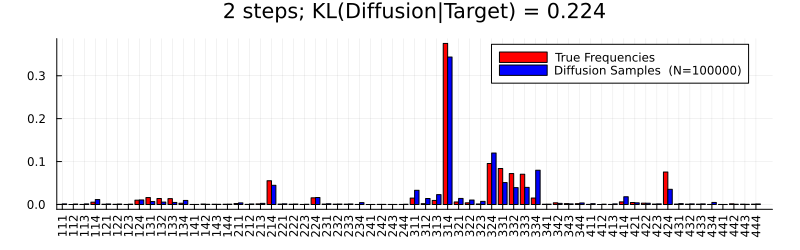

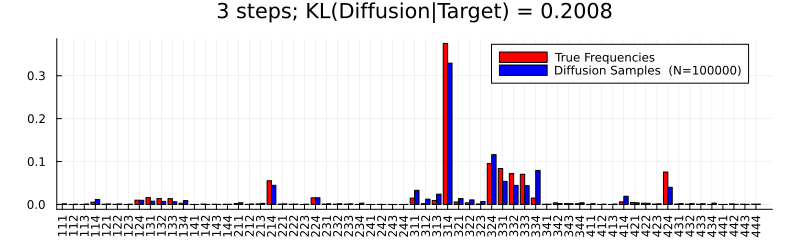

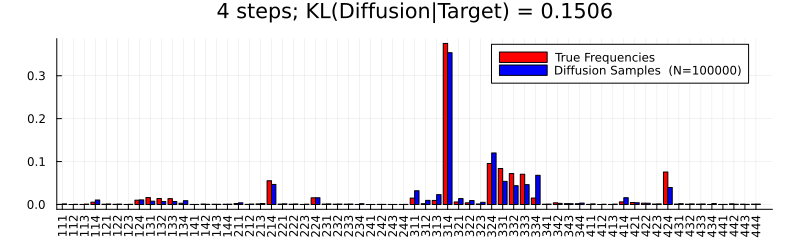

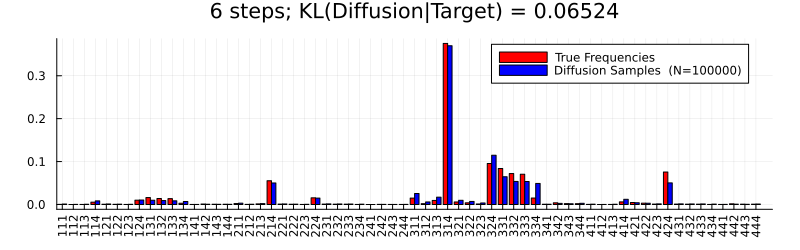

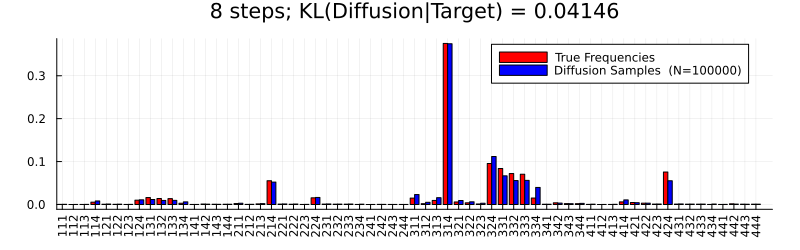

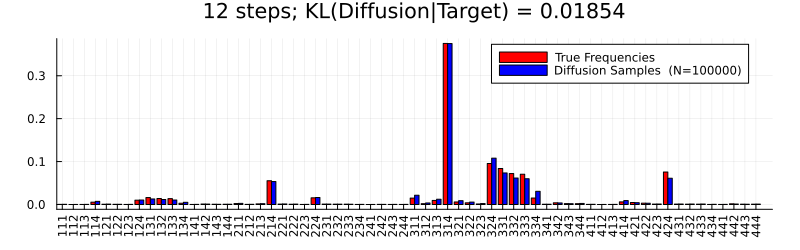

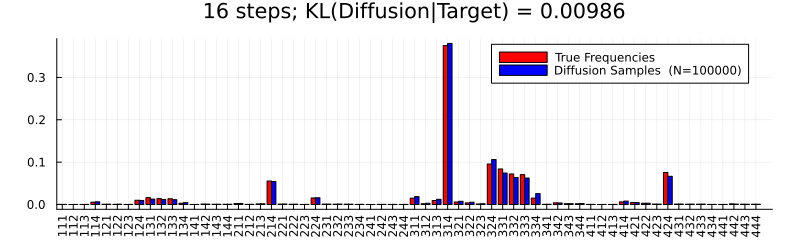

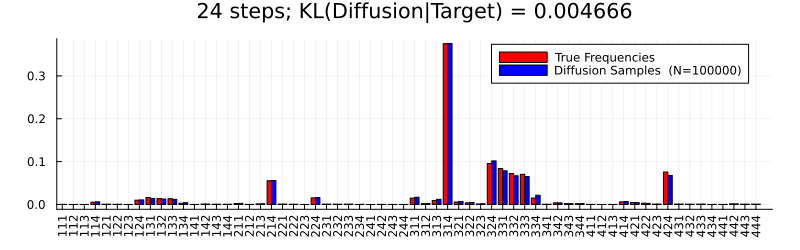

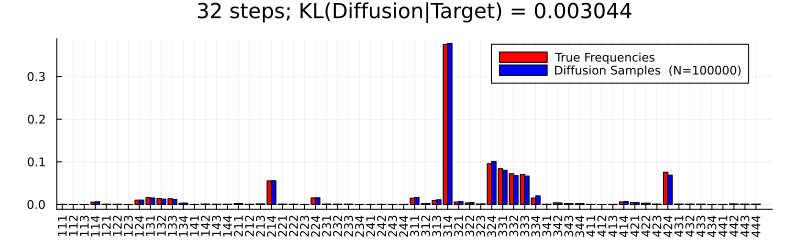

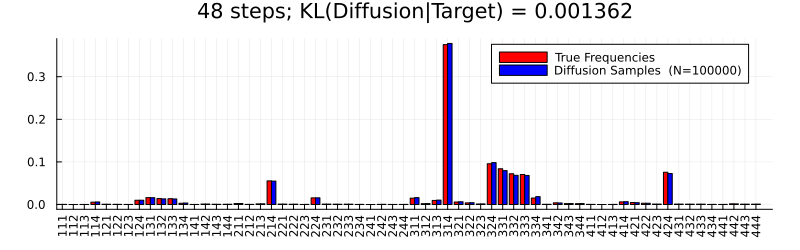

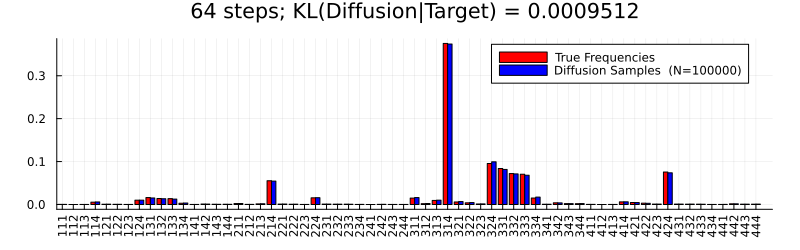

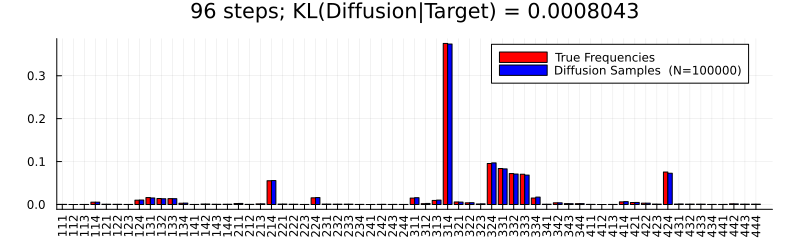

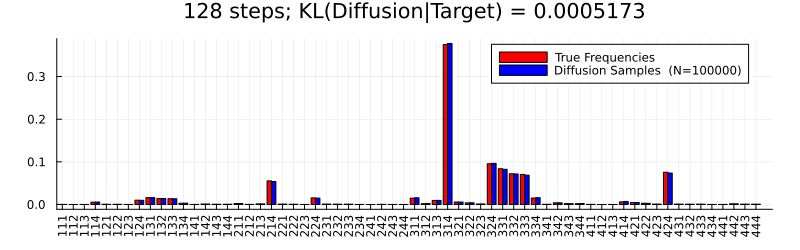

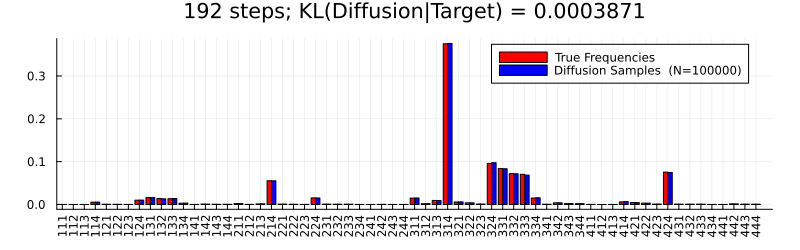

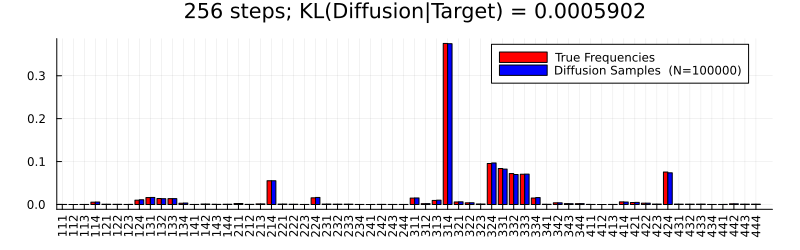

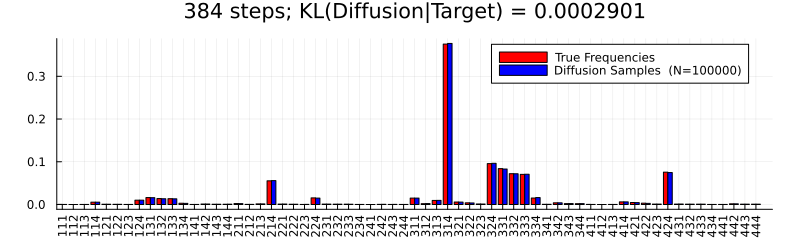

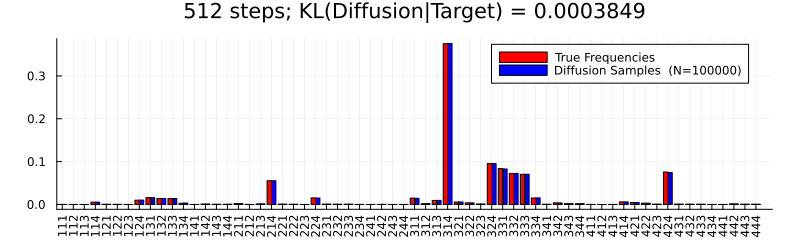

In [15]:
#Investigating the convergence on the true joint distribution using the direct expectation calculation
KLterm(p,q) = p > 0 ? p*log(p/q) : 0.0
KLdiv(Pdict,Qdict) = sum([KLterm(get(Pdict,k,0.0),get(Qdict,k,0.0)) for k in union(keys(Pdict),keys(Qdict))])

KLDs = Float64[]

steplist = [2,3,4,6,8,12,16,24,32,48,64,96,128,192,256,384,512]
for steps in steplist
    timesteps = log_schedule(Float32(0.001),Float32(20.0),steps+1)

    eq = Categorical(ones(alph)./alph);
    N = 100000
    x_T = onehotbatch(hcat([[rand(eq) for i in 1:3] for i in 1:N]...), 1:alph);

    samp = onecold(samplebackward(direct_zero_sample, P, timesteps, x_T),1:alph);
    diff_samples = [samp[:,i] for i in 1:size(samp,2)];
    prop_d = proportionmap(diff_samples)
    

    diff_freqs = [get(prop_d,a,0.0) for a in all_seqs]
    
    kld = round(KLdiv(prop_d,Dict(zip(all_seqs,all_probs))), sigdigits = 4)
    push!(KLDs,kld)
    
    pl = groupedbar([join(string.(a)) for a in all_seqs], [all_probs diff_freqs],
        xrotation = 90, size = (800,250), label = ["True Frequencies" "Diffusion Samples  (N=$(N))"],
        color = ["red" "blue"], margins = 0.5Plots.cm, xlim = (0,65), title = "$(steps) steps; KL(Diffusion|Target) = $(kld)")
    display(pl)
    if steps in [2,16,64,256]
        savefig(pl,"discrete_diff_direct_$(steps)_steps.pdf")
    end
end

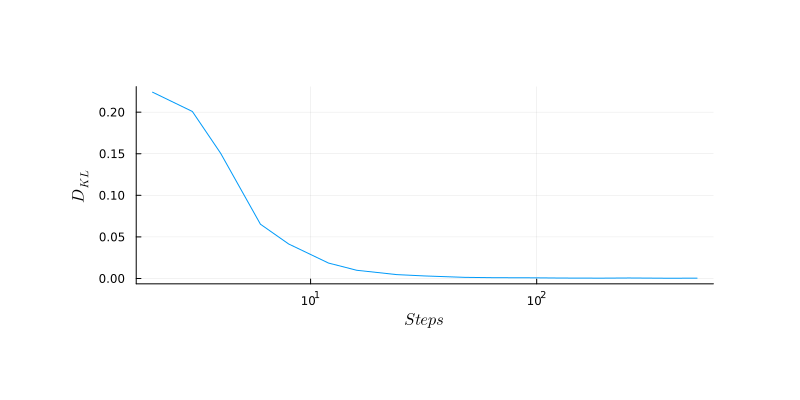

In [16]:
#KL divergence of samples vs true distribution as sampling steps increases
pl = plot(steplist, KLDs, xscale = :log10, size = (800,400),
    ylabel = L"D_{KL}", margins = 2Plots.cm, label = :none, xlabel = L"Steps")
savefig(pl,"discrete_KL_vs_steps_logschedule.pdf")
pl

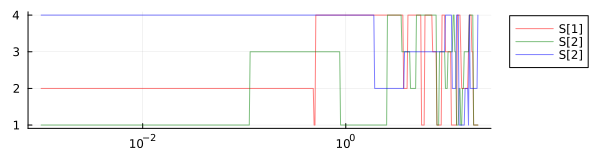

In [17]:
#A trajectory with an directly calculated zero sample
x_T = onehotbatch(hcat([[rand(eq) for i in 1:3] for i in 1:1]...), 1:alph);
track = Diffusions.Tracker()
samp = onecold(samplebackward(direct_zero_sample, P, timesteps, x_T, tracker = track),1:alph);

#An example of a single discrete trajectory
plot(track.time,hcat([v[:] for v in onecold.(track.data,(1:alph,))]...)', xscale = :log10, alpha = 0.5, size = (600,150), 
    legend=:outertopright, color = ["red" "green" "blue"], label = ["S[1]" "S[2]" "S[2]"])